#### **Problem №1: Closed Loop Chain**

Consider the following system:

<p align="center">
<img src="https://simeon-ned.github.io/robotic_systems/assets/images/systems/closed_loop.svg" alt="drawing" width="60%" style="margin:auto"/>
</p>

Do the following:

* **[5 points]** Choose the coordinates to represent the dynamics of your system, derive the free dynamics in this coordinates (you may use Euler-Lagrange or just Newton laws), write the set of holonomic constraints that represent the closed chain in form $\boldsymbol{\varphi}(\mathbf{q}) = 0$. Find the constraint Jacobian $\mathbf{J} = \frac{\partial\boldsymbol{\varphi}}{\partial\mathbf{q}}$ and it's derivative $\dot{\mathbf{J}}$ as function of $\mathbf{q}$ and $\dot{\mathbf{q}}$

* **[15 points]** Use either Lagrange or Udwadia-Kalaba approach with Runge-Kutta 4-th order integrator to simulate the motion of the system provided sample rate $dT = 0.01$ and feasible initial point $\mathbf{q}(0)$ in the rest. Calculate and plot the constraints penalization along the simulated trajectory $\|\boldsymbol{\varphi}(\mathbf{q}(t))\|$. Introduce and tune the Baumgarte stabilization technique to reduce constraint penalization. Animate the motion. 

* **[10 points]** Introduce the external torques $u_{1,2} = 3\sin(t)$ in to the static joints, repeat the steps above. 

---

In [61]:
import sympy as sp

t = sp.symbols('t', real=True)
m1, m2, l, L, g = sp.symbols('m1 m2 l L g')
q = sp.symbols(r'x1, y1, x2, y2', cls=sp.Function)
q = sp.Matrix([q[i](t) for i in range(len(q))])
dq = sp.Matrix([sp.diff(q[i], t) for i in range(len(q))])
ddq = sp.Matrix([sp.diff(dq[i], t) for i in range(len(q))])

q, dq, ddq

(Matrix([
 [x1(t)],
 [y1(t)],
 [x2(t)],
 [y2(t)]]),
 Matrix([
 [Derivative(x1(t), t)],
 [Derivative(y1(t), t)],
 [Derivative(x2(t), t)],
 [Derivative(y2(t), t)]]),
 Matrix([
 [Derivative(x1(t), (t, 2))],
 [Derivative(y1(t), (t, 2))],
 [Derivative(x2(t), (t, 2))],
 [Derivative(y2(t), (t, 2))]]))

In [62]:
# constraints
phi = sp.Matrix([
    # first joint is at l from (0, 0)
    [q[0]**2 + q[1]**2 - l**2],
    # second joint is at l from (L, 0)
    [(q[2] - L)**2 + q[3]**2 - l**2],
    # distance between joints is l
    [(q[0] - q[2])**2 + (q[1] - q[3])**2 - l**2],
])

jacobian = phi.jacobian(q)
jacobian

Matrix([
[          2*x1(t),           2*y1(t),                  0,                  0],
[                0,                 0,     -2*L + 2*x2(t),            2*y2(t)],
[2*x1(t) - 2*x2(t), 2*y1(t) - 2*y2(t), -2*x1(t) + 2*x2(t), -2*y1(t) + 2*y2(t)]])

In [63]:
# mass matrix
M = sp.diag(m1, m1, m2, m2)

M

Matrix([
[m1,  0,  0,  0],
[ 0, m1,  0,  0],
[ 0,  0, m2,  0],
[ 0,  0,  0, m2]])

In [64]:
u = sp.symbols('u1:3')

h = sp.Matrix([
    [u[0] * q[0] / (q[0]**2 + q[1]**2)],
    [-m1 * g + u[0] * q[1] / (q[0]**2 + q[1]**2)],
    [u[1] * q[2] / ((q[2] - L)**2 + q[3]**2)],
    [-m2 * g + u[1] * q[3] / ((q[2] - L)**2 + q[3]**2)],
])

h

Matrix([
[               u1*x1(t)/(x1(t)**2 + y1(t)**2)],
[       -g*m1 + u1*y1(t)/(x1(t)**2 + y1(t)**2)],
[        u2*x2(t)/((-L + x2(t))**2 + y2(t)**2)],
[-g*m2 + u2*y2(t)/((-L + x2(t))**2 + y2(t)**2)]])

In [65]:
LHS = sp.Matrix([
    [M, jacobian.T],
    [jacobian, sp.zeros(jacobian.shape[0], jacobian.shape[0])],
])

LHS

Matrix([
[               m1,                 0,                  0,                  0, 2*x1(t),              0,  2*x1(t) - 2*x2(t)],
[                0,                m1,                  0,                  0, 2*y1(t),              0,  2*y1(t) - 2*y2(t)],
[                0,                 0,                 m2,                  0,       0, -2*L + 2*x2(t), -2*x1(t) + 2*x2(t)],
[                0,                 0,                  0,                 m2,       0,        2*y2(t), -2*y1(t) + 2*y2(t)],
[          2*x1(t),           2*y1(t),                  0,                  0,       0,              0,                  0],
[                0,                 0,     -2*L + 2*x2(t),            2*y2(t),       0,              0,                  0],
[2*x1(t) - 2*x2(t), 2*y1(t) - 2*y2(t), -2*x1(t) + 2*x2(t), -2*y1(t) + 2*y2(t),       0,              0,                  0]])

In [66]:
RHS = sp.zeros(len(q) + len(phi), 1)

RHS[:len(q), 0] = h
RHS[len(q):, 0] = -jacobian.diff(t) @ dq  - 100 * phi - 100 * jacobian @ dq

RHS

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                u1*x1(t)/(x1(t)**2 + y1(t)**2)],
[                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [67]:
params = dict(
    m1=0.5,
    m2=0.7,
    l=0.25,
    L=0.4,
    g=9.81,
)

LHS = LHS.subs(params)
RHS = RHS.subs(params)

numerical = dict(
    LHS=sp.lambdify((t, q, dq), LHS),
    RHS=sp.lambdify((t, q, dq, u), RHS),
)

In [68]:
import numpy as np

def get_intersections(x0, y0, r0, x1, y1, r1):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1

    d=np.sqrt((x1-x0)**2 + (y1-y0)**2)
    
    # non intersecting
    if d > r0 + r1 :
        return None
    # One circle within other
    if d < abs(r0-r1):
        return None
    # coincident circles
    if d == 0 and r0 == r1:
        return None
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=np.sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d   
        y2=y0+a*(y1-y0)/d   
        x3=x2+h*(y1-y0)/d     
        y3=y2-h*(x1-x0)/d 

        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        
        return (x3, y3)

# Simulate with zero torques

In [69]:
from scipy.integrate import solve_ivp
import numpy as np
q0 = np.array([
    0,
    params['l'],
    *get_intersections(0, params['l'], params['l'], params['L'], 0, params['l']),
])
dq0 = np.array([0, 0, 0, 0])

def f(t, x):
    q_num, dq_num = np.split(x, 2)

    u = np.array([0, 0])

    M = numerical['LHS'](t, q_num, dq_num)
    RHS = numerical['RHS'](t, q_num, dq_num, u)

    ddqlambda = np.linalg.solve(M, RHS)

    ddq = ddqlambda[:len(q)]
    lambdas = ddqlambda[len(q):]
    return np.concatenate([dq_num, ddq.T[0]])

t = np.arange(0, 10, 0.01)

zero_torques_sim = solve_ivp(f, np.array([t[0], t[-1]]), np.concatenate([q0, dq0]), 'RK45', t)


In [70]:
q0

array([0.        , 0.25      , 0.15605481, 0.0546877 ])

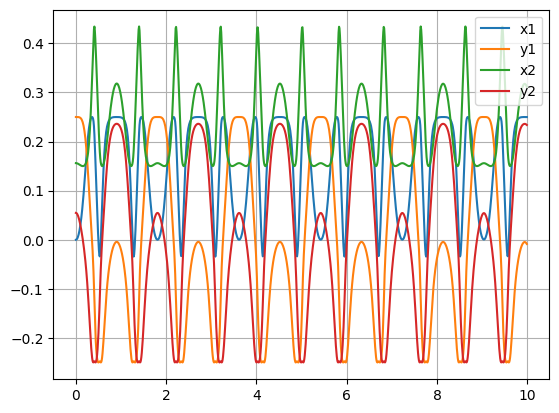

In [71]:
import matplotlib.pyplot as plt

# plot how coordinates change over time
plt.plot(t, zero_torques_sim.y[0], label='x1')
plt.plot(t, zero_torques_sim.y[1], label='y1')
plt.plot(t, zero_torques_sim.y[2], label='x2')
plt.plot(t, zero_torques_sim.y[3], label='y2')
plt.legend()
plt.grid()

plt.show()

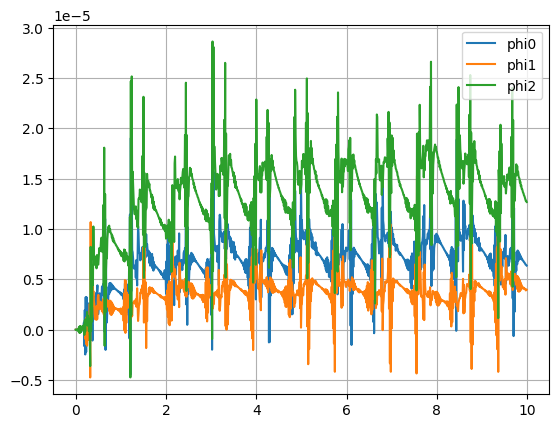

In [72]:
import matplotlib.pyplot as plt

# lambdify constraints
phi = phi.subs(params)
phiNum = sp.lambdify((q, ), phi)

constraints = []
for i, ti in enumerate(zero_torques_sim.t):
    phi_i = phiNum(zero_torques_sim.y[:, i][:len(q)])
    constraints.append(phi_i.T[0])


# plot how constraints change over time
plt.plot(zero_torques_sim.t, constraints, label=[f'phi{i}' for i in range(len(phi))])
plt.legend()
plt.grid()

In [73]:
import json

with open('data/problem1_no_torques.json', 'w') as f:
    # save [time, x0, y0, x1, y1, x2, y2, x3, y3]
    result = []
    for i, ti in enumerate(zero_torques_sim.t):
        q = zero_torques_sim.y[:, i][:len(q)]
        result.append([ti, 0, 0, *q, params['L'], 0])
    
    result = np.array(result)

    json.dump(result.tolist(), f)

# Apply torques

In [74]:
from scipy.integrate import solve_ivp
import numpy as np
q0 = np.array([
    0,
    params['l'],
    *get_intersections(0, params['l'], params['l'], params['L'], 0, params['l']),
])
dq0 = np.array([0, 0, 0, 0])

def f(t, x):
    q_num, dq_num = np.split(x, 2)

    u = np.array([3 * np.sin(t), 3 * np.sin(t)])

    M = numerical['LHS'](t, q_num, dq_num)
    RHS = numerical['RHS'](t, q_num, dq_num, u)

    ddqlambda = np.linalg.solve(M, RHS)

    ddq = ddqlambda[:len(q)]
    lambdas = ddqlambda[len(q):]
    return np.concatenate([dq_num, ddq.T[0]])

t = np.arange(0, 5, 0.01)

sim = solve_ivp(f, np.array([t[0], t[-1]]), np.concatenate([q0, dq0]), 'RK45', t)


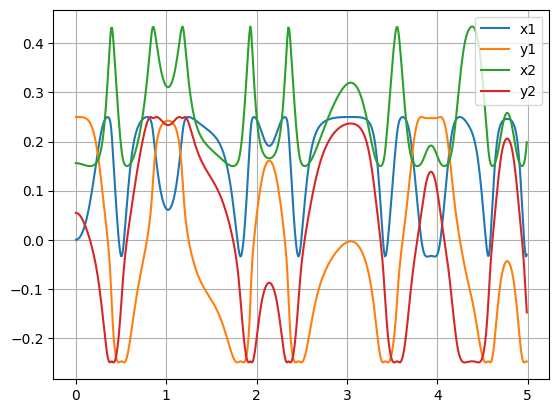

In [75]:
import matplotlib.pyplot as plt

# plot how coordinates change over time
plt.plot(t, sim.y[0], label='x1')
plt.plot(t, sim.y[1], label='y1')
plt.plot(t, sim.y[2], label='x2')
plt.plot(t, sim.y[3], label='y2')
plt.legend()
plt.grid()

plt.show()

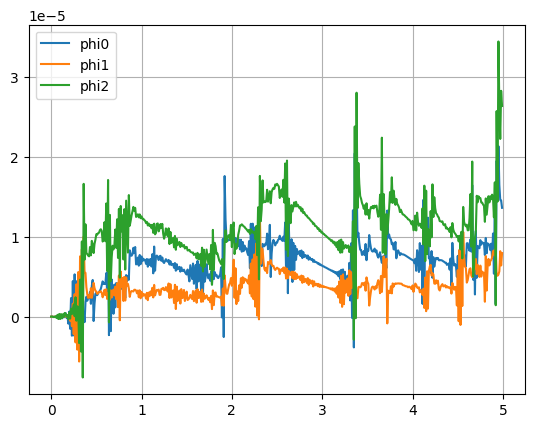

In [76]:
import matplotlib.pyplot as plt

constraints = []
for i, ti in enumerate(sim.t):
    phi_i = phiNum(sim.y[:, i][:len(q)])
    constraints.append(phi_i.T[0])


# plot how constraints change over time
plt.plot(sim.t, constraints, label=[f'phi{i}' for i in range(len(phi))])
plt.legend()
plt.grid()

In [77]:
import json

with open('data/problem1_torques.json', 'w') as f:
    # save [time, x0, y0, x1, y1, x2, y2, x3, y3]
    result = []
    for i, ti in enumerate(sim.t):
        q = sim.y[:, i][:len(q)]
        result.append([ti, 0, 0, *q, params['L'], 0])
    
    result = np.array(result)

    json.dump(result.tolist(), f)